## Test individual sea level contributors

In [6]:
import glob
import importlib
import sys
sys.path.append('../code')

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import xarray as xr
from IPython.display import display

import func_odyn as odyn
import func_misc as misc
import func_gic as gic
import func_gre as gre
import func_ant as ant
import func_B19 as b19


In [7]:
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [2]:
importlib.reload(odyn)
importlib.reload(misc)
importlib.reload(ant)


<module 'func_ant' from '../code/func_ant.py'>

In [2]:
SCE = 'rcp85'
ROOT = '/Users/dewilebars/Projects/Project_ProbSLR/Data_Proj/'
DIR_T_cmip5 = f'{ROOT}Data_AR5/Tglobal/'
DIR_T_cmip6 = f'{ROOT}Data_cmip6/tas_global_averaged_climate_explorer/'
DIR_IPCC = ROOT+'Data_AR5/Final_Projections/'
DIR_O       = ROOT + 'Data_AR5/Ocean/1x1_reg/'
DIR_OG      = ROOT + 'Data_AR5/Ocean/globalmeans_from_1x1_glob/'

N = int(1e5)
start_date = 1980    # Start reading data
ys = 2006   # Starting point for the integration, if this is changed problems in functions
ye = 2100   # End year for computation
nb_y = ye-start_date+1       # Period where data needs to be read
nb_y2 = ye - ys +1           # Period of integration of the model
TIME       = np.arange( start_date, ye + 1 )
TIME2      = np.arange( ys, ye + 1, 1 )
GAM = 1
GRE = 'KNMI14'
NormD  = np.random.normal(0, 1, N)
Aoc = 3.6704e14              # Ocean Area (m2)
rho_w = 1e3                  # Water density (kg.m-3)
fac = -1e12 / (Aoc * rho_w)  # Convert Giga tones to m sea level
MOD = ["ACCESS1-0","BCC-CSM1-1","CanESM2","CNRM-CM5","CSIRO-Mk3-6-0","GFDL-ESM2G", \
    "GFDL-ESM2M","GISS-E2-R","HadGEM2-CC","HadGEM2-ES","inmcm4","IPSL-CM5A-LR", \
    "IPSL-CM5A-MR","MIROC5","MIROC-ESM-CHEM","MIROC-ESM","MPI-ESM-LR","MPI-ESM-MR", \
    "MRI-CGCM3","NorESM1-ME","NorESM1-M"]
i_ys   = np.where(TIME == ys)[0][0]

#### Specific parameters
## Initial Antarctic dynamics contribution
a1_up_a           = 0.061    # Unit is cm/y, equal to observations in 2006
a1_lo_a           = 0.021
## Initial Greenland dynamics contribution
a1_up_g           = 0.076    # Unit is cm/y, equal to observations in 2006
a1_lo_g           = 0.043

ref_steric = [1986, 2005] # Reference period for steric sea level

In [3]:
def comp_plot_dist(X_ens, lo, hi, title_in, SCE):
    '''Easily compute the distribution, plot a histogram and table of percentile 
    values'''
    nbin = int(hi - lo)*20 
    X_pdf, bins = np.histogram(X_ens, bins=nbin, range=(lo, hi), density=True)
    bin_centers = (bins[1:] + bins[:-1])/2

    plt.bar(bin_centers, X_pdf, width=1)
    plt.ylabel('PDF')
    plt.title(title_in + ' for '+SCE)
    plt.show()
    
    Perc  = (1,5,10,17,20,50,80,83,90,95,99,99.5,99.9)
    perc = misc.perc_df(X_pdf, Perc, bin_centers)
    print("### Distribution ###")
    display(perc)

### Test ocean dynamics function: odyn.odyn_glob_ipcc

(3, 100000, 95)


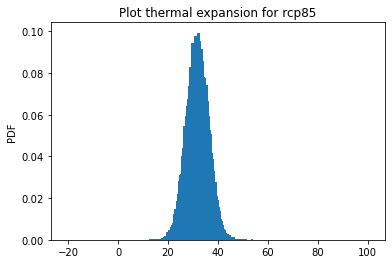

### Distribution ###


,values
percentiles,
1.0,21.725
5.0,24.675
10.0,26.225
17.0,27.625
20.0,28.125
50.0,31.775
80.0,35.425
83.0,35.875
90.0,37.275


In [4]:
X_O = odyn.odyn_glob_ipcc(SCE, DIR_IPCC, N, nb_y2, GAM, NormD)
print(X_O.shape)
comp_plot_dist(X_O[0,:,-1], -20.5, 100.5, 'Plot thermal expansion', SCE)


### Test ocean dynamics function: odyn.odyn_loc

(3, 100000, 95)


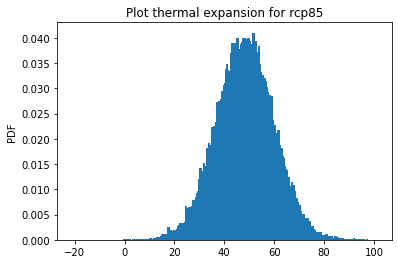

### Distribution ###


,values
percentiles,
1.0,22.775
5.0,30.325
10.0,34.225
17.0,37.825
20.0,39.075
50.0,48.325
80.0,57.525
83.0,58.725
90.0,62.275


In [5]:
LOC = 60, 51, -3.5, 7.5 # lat_N, lat_S, lon_W, lon_E
LowPass = False

X_O = odyn.odyn_loc(SCE, MOD, DIR_O, DIR_OG, LOC, 
                    ref_steric, ye, N, ys, GAM, NormD, LowPass)
print(X_O.shape)
comp_plot_dist(X_O[0,:,-1], -20.5, 100.5, 'Plot thermal expansion', SCE)


### Test ocean dynamics function: odyn.odyn_cmip

In [4]:
# Works for ye greater than 2100 if LowPass is on by extrapolating a 2nd order fit of each model in the future 
importlib.reload(odyn)

<module 'func_odyn' from '../code/func_odyn.py'>

In [9]:
LowPass = False
LOC = [60, 51, -3.5, 7.5]
DIR_CMIP = '../../CMIP_SeaLevel/outputs/'

X_O2 = odyn.odyn_cmip('ssp585', DIR_CMIP, LOC, 
                     ref_steric, 2100, N, ys, GAM, NormD, LowPass)
print(X_O2.shape)
comp_plot_dist(X_O2[0,:,-1], -20.5, 200.5, 'Plot thermal expansion', SCE)

TypeError: odyn_cmip() missing 1 required positional argument: 'BiasCorr'

In [10]:
X_O2 = odyn.odyn_cmip('rcp85', DIR_CMIP, LOC, 
                     ref_steric, 2100, N, ys, GAM, NormD, LowPass)
print(X_O2.shape)
comp_plot_dist(X_O2[0,:,-1], -20.5, 200.5, 'Plot thermal expansion', SCE)

TypeError: odyn_cmip() missing 1 required positional argument: 'BiasCorr'

### Test the temperature projection function

In [11]:
importlib.reload(misc)

<module 'func_misc' from '../code/func_misc.py'>

In [12]:
def plot_dist(X_ens, title_in, SCE):
    
    X_ens_df = pd.DataFrame(X_ens)
    X_ens_df.hist(bins=100)
    
    Perc  = np.array([1,5,10,17,20,50,80,83,90,95,99,99.5,99.9])
    perc_df = pd.DataFrame(X_ens_df.quantile(Perc/100))
    perc_df.index.name = 'Percentiles'
    perc_df.index = perc_df.index*100
    plt.ylabel('PDF')
    plt.title(f'{title_in} for {SCE}')
    plt.show()
    
    print("### Distribution ###")
    display(perc_df)
    

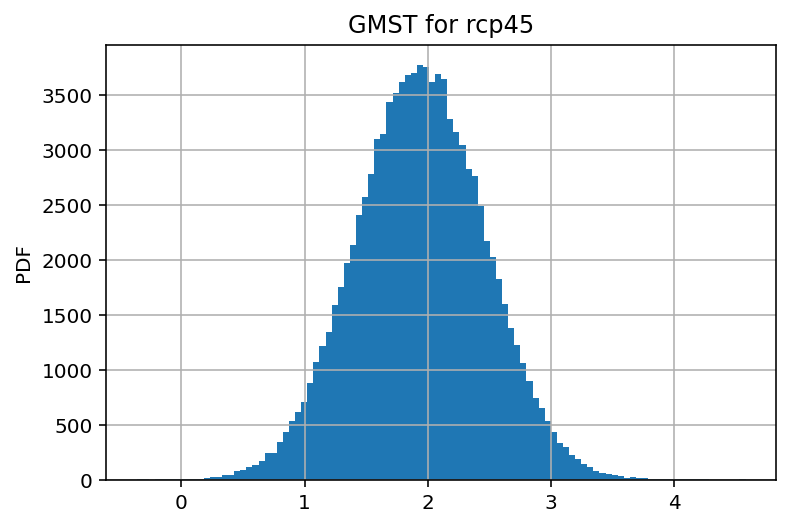

### Distribution ###


,0
Percentiles,
1.0,0.723892
5.0,1.082681
10.0,1.270101
17.0,1.442137
20.0,1.501503
50.0,1.941569
80.0,2.381302
83.0,2.438649
90.0,2.608222


In [13]:
# For AR5
LowPass = False
SCE = 'rcp45'
ye = 2100

TGLOB = misc.make_tglob_array( ROOT, 'AR5',SCE, start_date, ye , LowPass)
TGLOBs = TGLOB.sel(time=slice(ys,None))
T_gic = TGLOBs - TGLOB.sel(time=slice(1986,2005)).mean(dim='time')
Td_gic = misc.normal_distrib(T_gic, GAM, NormD)
plot_dist(Td_gic[:,-1], 'GMST', SCE)

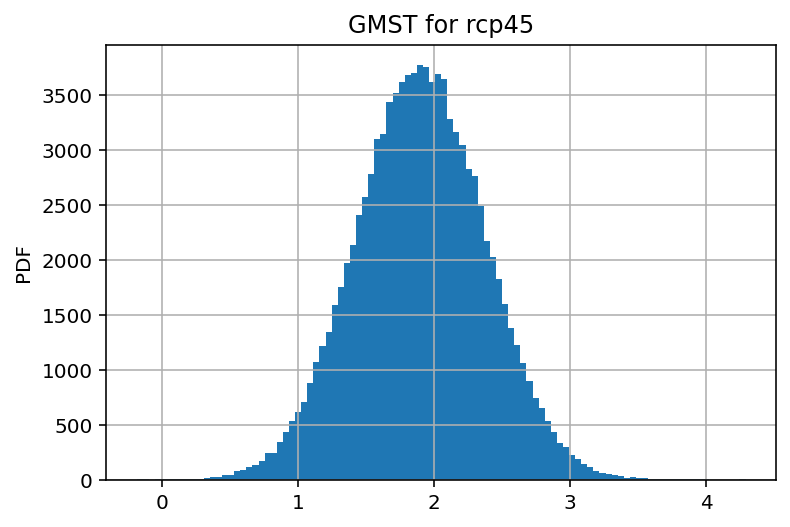

### Distribution ###


,0
Percentiles,
1.0,0.798951
5.0,1.123398
10.0,1.292879
17.0,1.448448
20.0,1.502132
50.0,1.900077
80.0,2.297720
83.0,2.349577
90.0,2.502919


In [14]:
# For CMIP5
LowPass = False
SCE = 'rcp45'
ye = 2100

TGLOB = misc.make_tglob_array( ROOT, 'CMIP5',SCE, start_date, ye , LowPass)
TGLOBs = TGLOB.sel(time=slice(ys,None))
T_gic = TGLOBs - TGLOB.sel(time=slice(1986,2005)).mean(dim='time')
Td_gic = misc.normal_distrib(T_gic, GAM, NormD)
plot_dist(Td_gic[:,-1], 'GMST', SCE)

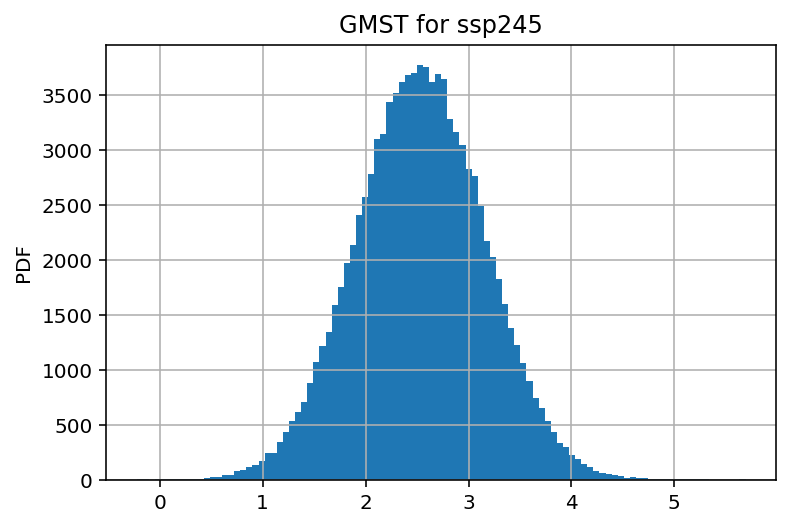

### Distribution ###


,0
Percentiles,
1.0,1.076459
5.0,1.505745
10.0,1.729990
17.0,1.935828
20.0,2.006859
50.0,2.533393
80.0,3.059527
83.0,3.128141
90.0,3.331033


In [15]:
#For CMIP6
LowPass = False
SCE = 'ssp245'
ye = 2100

TGLOB = misc.make_tglob_array(ROOT, 'CMIP6', SCE, start_date, ye , LowPass)
TGLOBs = TGLOB.sel(time=slice(ys,None))
T_gic = TGLOBs - TGLOB.sel(time=slice(1986,2005)).mean(dim='time')
Td_gic = misc.normal_distrib(T_gic, GAM, NormD)
plot_dist(Td_gic[:,-1], 'GMST', SCE)


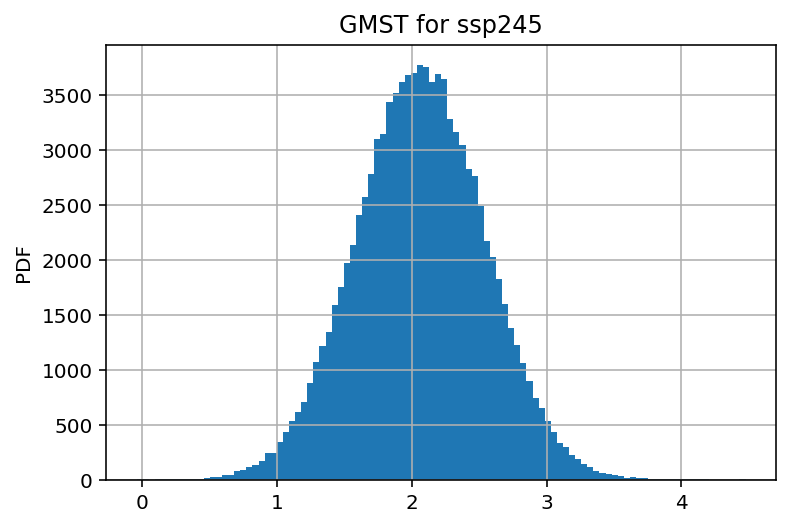

### Distribution ###


,0
Percentiles,
1.0,0.951070
5.0,1.278952
10.0,1.450228
17.0,1.607444
20.0,1.661696
50.0,2.063855
80.0,2.465708
83.0,2.518115
90.0,2.673080


In [16]:
#For CMIP6
LowPass = False
SCE = 'ssp245'
ye = 2100

TGLOB = misc.make_tglob_array(ROOT, 'AR6', SCE, start_date, ye , LowPass)
TGLOBs = TGLOB.sel(time=slice(ys,None))
T_gic = TGLOBs - TGLOB.sel(time=slice(1986,2005)).mean(dim='time')
Td_gic = misc.normal_distrib(T_gic, GAM, NormD)
plot_dist(Td_gic[:,-1], 'GMST', SCE)

### Test the glacier projection function

In [17]:
importlib.reload(gic)

<module 'func_gic' from '../code/func_gic.py'>

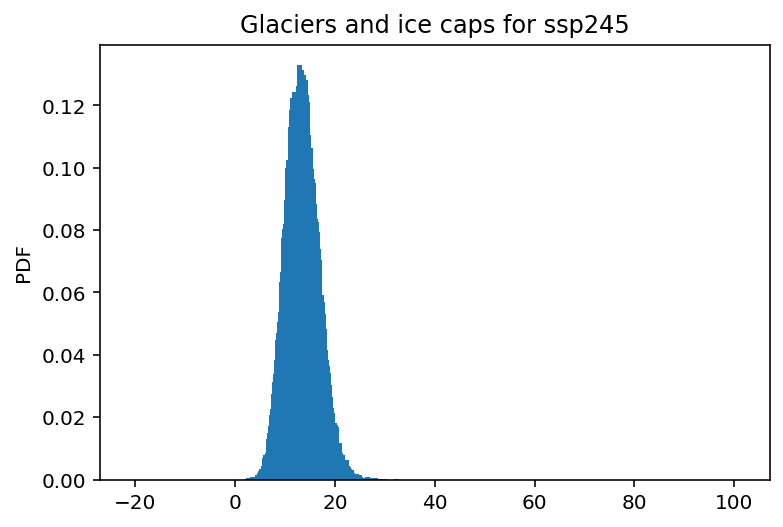

### Distribution ###


,values
percentiles,
1.0,6.675
5.0,8.425
10.0,9.425
17.0,10.325
20.0,10.625
50.0,13.225
80.0,16.025
83.0,16.425
90.0,17.575


In [20]:
NormDs  = np.random.normal(0, 1, N)   # This distribution is then kept for correlation
X_gic = gic.gic_ipcc(Td_gic, NormDs, 'AR5')
comp_plot_dist(X_gic[:,-1], -20.5, 100.5, 'Glaciers and ice caps', SCE)


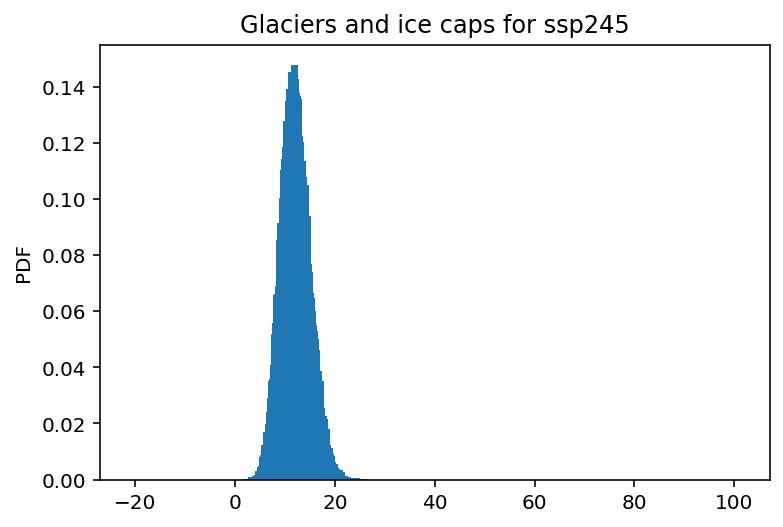

### Distribution ###


,values
percentiles,
1.0,5.975
5.0,7.525
10.0,8.425
17.0,9.275
20.0,9.575
50.0,11.875
80.0,14.425
83.0,14.775
90.0,15.825


In [21]:
NormDs  = np.random.normal(0, 1, N)   # This distribution is then kept for correlation
X_gic = gic.gic_ipcc(Td_gic, NormDs, 'AR6')
comp_plot_dist(X_gic[:,-1], -20.5, 100.5, 'Glaciers and ice caps', SCE)


### Test the Greenland SMB function

In [ ]:
T_g = TGLOBs - TGLOB.sel(time=slice(1980,1999)).mean(dim='time')
Td_g = misc.normal_distrib(T_g, GAM, NormD)

NormDl = np.random.normal(0, 1, N)
X_gsmb = gre.fett13(fac, Td_g, NormDl, GRE)
comp_plot_dist(X_gsmb[:,-1], -20.5, 100.5, 'Greenland SMB', SCE)

### Test Antarctic SMB

In [ ]:
Tref_a = misc.Tref(1985, 2005, TGLOB, TIME)   # Antarctic SMB
Td_a = misc.TempDist(TGLOBs, Tref_a, GAM, NormD)
NormDl = np.random.normal(0, 1, N)
X_asmb = ant.ant_smb_ar5(NormDl, fac, Td_a)
comp_plot_dist(X_asmb[:,-1], -20.5, 100.5, 'Antarctic SMB', SCE)

### Test land water storage

In [ ]:
X_landw = misc.landw_ar5(ys, TIME2, N)
comp_plot_dist(X_landw[:,-1], -20.5, 100.5, 'Land water changes', SCE)

### Test Antarctic dynamics

### AR5

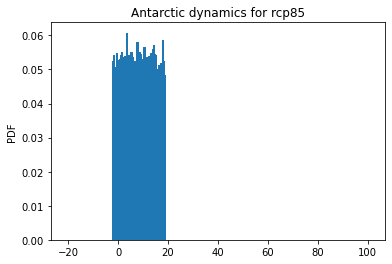

### Distribution ###


,values
percentiles,
1.0,-1.825
5.0,-0.975
10.0,0.025
17.0,1.475
20.0,2.025
50.0,8.225
80.0,14.375
83.0,14.925
90.0,16.425


In [34]:
Unif_AA   = np.random.uniform(0, 1, N)
#### 2nd order projection starting from observations and ending between -2 and 18.5 cm
X_ant = misc.proj2order(TIME2, a1_up_a, a1_lo_a, 18.5, -2, Unif_AA)
comp_plot_dist(X_ant[:,-1], -20.5, 100.5, 'Antarctic dynamics', SCE)

### SROCC

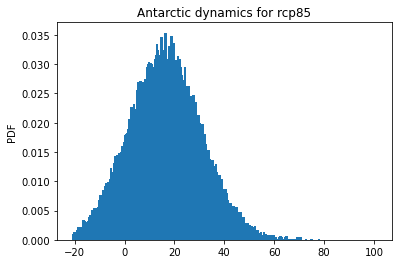

### Distribution ###


,values
percentiles,
1.0,-14.425
5.0,-6.475
10.0,-1.675
17.0,2.775
20.0,4.325
50.0,15.975
80.0,27.725
83.0,29.325
90.0,33.925


In [35]:
X_ant = ant.ant_dyn_srocc(SCE, a1_up_a, a1_lo_a, TIME2, N)
comp_plot_dist(X_ant[:,-1], -20.5, 100.5, 'Antarctic dynamics', SCE)

### AR6

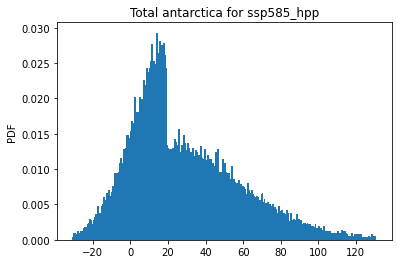

### Distribution ###


,values
percentiles,
1.0,-19.625
5.0,-8.675
10.0,-2.725
17.0,2.775
20.0,4.725
50.0,18.975
80.0,49.975
83.0,54.075
90.0,66.025


In [42]:
SCE = 'ssp585_hpp'
X_ant = ant.ant_ar6(TIME2, a1_up_a, a1_lo_a, SCE, NormD)
comp_plot_dist(X_ant[:,-1], -30.5, 130.5, 'Total antarctica', SCE)

### Test Greenland dynamics

In [ ]:
# First order term (cm/y), equal to half of observations in 2006
a1_up_gdyn        = 0.5 * a1_up_g
a1_lo_gdyn        = 0.5 * a1_lo_g
UnifDd = np.random.uniform(0, 1, N)  # Sample a new independent distribution

if GRE == 'KNMI14':
    X_gre  = misc.proj2order(TIME2, a1_up_gdyn, a1_lo_gdyn, 7.4, 1.7, UnifDd)
elif GRE == 'IPCC':
    if SCE in ['rcp26', 'rcp45']:
        Delta_gre_up_2100 = 6.3
        Delta_gre_lo_2100 = 1.4
    elif SCE == 'rcp85':
        Delta_gre_up_2100 = 8.5
        Delta_gre_lo_2100 = 2
    X_gre  = misc.proj2order(TIME2, a1_up_gdyn, a1_lo_gdyn, Delta_gre_up_2100, 
                        Delta_gre_lo_2100, UnifDd)
comp_plot_dist(X_gre[:,10], -20.5, 100.5, 'Greenland dynamics', SCE)

lo = -20.5
hi = 100.5
nbin = int(hi - lo) 
X_gre_pdf, bins = np.histogram(X_gre[:,10], bins=nbin, range=(lo, hi), density=True)
X_gre_pdf

### Test antarctic dynamics from KNMI14 projections 

In [ ]:
X_ant_KNMI14 = ant.ant_dyn_knmi14(SCE, a1_up_a, a1_lo_a, ys, ye, TIME2, N)
comp_plot_dist(X_ant_KNMI14[:,-1], -20.5, 100.5, 'Antarctic dynamics KNMI14', 
               SCE)


### Tables of global results

In [ ]:
AR5_df = pd.read_csv('../ref_results/SLR_AR5_2100', sep=';', comment='#') # , header=1
AR5_df = AR5_df.set_index('Processes')
AR5_df


### Test Bamber et al. 2019 functions

In [ ]:
importlib.reload(b19)

In [ ]:
path = '../../BamberDataDistribution/parameters_mean_std_opt.csv'
PAR_ar = b19.ReadB19(path)
PAR_ar

In [ ]:
# Bamber et al. 2019 temperature pathways
t0 = 2000
t1 = 2050
t2 = 2100

# First order interpolation along temperature integral
# Define the temperature functions for the low and high scenarios
T0 = 0.8     # Should be floats, integers lead to problem in the computations
Tl50 = 1.5
Tl100 = 2.
Th50 = 2.
Th100 = 5.

Tl = b19.TempF(T0, Tl50, Tl100, t0, t1, t2)
Th = b19.TempF(T0, Th50, Th100, t0, t1, t2)

### Plot
t = np.arange(t0, t2+1)

fig, ax = plt.subplots()
ax.plot(t, Tl)
ax.plot(t, Th)

ax.set(xlabel='time (year)', ylabel='Temperature (ºC)',
       title='B19 scenarios')
ax.grid()

In [ ]:
# Greenland
GAM = 1.64
Tref_b   = misc.Tref(2000, 2000, TGLOB, TIME)
Td_b = misc.TempDist(TGLOBs, Tref_b, GAM, NormD)

UnifP_GIS = np.random.uniform(0, 1, N)

X_gsmb = b19.Bamber19('GIS', UnifP_GIS, [a1_lo_g, a1_up_g], ys, Td_b)
X_gsmb = X_gsmb + 0.3    # Contribution between 1995 and 2005 in mm

comp_plot_dist(X_gsmb[:,-1], -20.5, 350.5, 'Total Greenland B19', 
               SCE)
# !!! The above computation is sensitive to the right end of the 
#histogram computation

In [ ]:
# Antarctica
UnifP_WAIS = np.random.uniform(0, 1, N)
UnifP_EAIS = np.random.uniform(0, 1, N)

X_ant_wais = b19.Bamber19("WAIS", UnifP_WAIS, [a1_lo_a, a1_up_a], ys, Td_b)
X_ant_eais = b19.Bamber19("EAIS", UnifP_EAIS, [0, 0], ys, Td_b)
X_ant = X_ant_wais + X_ant_eais    # Contribution between 1995 and 2005 in mm

comp_plot_dist(X_ant[:,50], -100.5, 350.5, 'Total Atarctica B19', 
               SCE)

In [ ]:
comp_plot_dist(X_ant_wais[:,50], -20.5, 350.5, 'WAIS B19', 
               SCE)

In [ ]:
comp_plot_dist(X_ant_eais[:,-1], -20.5, 250.5, 'EAIS B19', 
               SCE)